In [1]:
library(tidyverse)
library(car)
library(olsrr)
library(stringr)
library(tidytext)
library(syuzhet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘car’ was built under R version 3.4.4”Loading required package: carData
Warning message:
“package ‘carData’ was built under R version 3.4.4”
Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘olsrr’

The following object is masked from ‘package:datasets’:

    rivers

Warning message:
“package ‘tidytext’ was built under R version 

In [2]:
# Make sure to change this
setwd("/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Text Analytics Project")

" 
Read in the CSV file
"
personality = as.tibble(read.csv("youtube-personality/YouTube-Personality-Personality_impression_scores_train.csv", 
                                 encoding = "UTF-8",
                                 sep = " "))

gender = as.tibble(read.csv("youtube-personality/YouTube-Personality-gender.csv",
                            encoding = "UTF-8",
                            sep = " "))

audiovisual = as.tibble(read.csv("youtube-personality/YouTube-Personality-audiovisual_features.csv",
                                 encoding = "UTF-8",
                                 sep = " "))

transcripts = as.tibble(read.csv("youtube-personality/transcripts.csv",
                                 encoding = "UTF-8",
                                 sep = ","))
transcripts$index = as.character(transcripts$index)

transcripts =
  transcripts %>%
  rename(vlogId = index,
         transcript = X0) %>%
  mutate(vlogId = substr(vlogId, 1, nchar(vlogId)-4))

personality$vlogId = as.character(personality$vlogId)
gender$vlogId = as.character(gender$vlogId)
audiovisual$vlogId = as.character(audiovisual$vlogId)

training_data = 
  personality %>%
  left_join(gender, on = c("vlogID" = "vlogID")) %>%
  left_join(audiovisual, on = c("vlogID" = "vlogID")) %>%
  left_join(transcripts, on = c("clogID" = "vlogID"))

#tokenization
training_data$transcript <- as.vector(training_data$transcript)
tidy_data <- training_data %>% 
  unnest_tokens(word, transcript, to_lower = TRUE) %>% 
  anti_join(get_stopwords())

#count the total number of words for each person
total_words <- tidy_data %>% 
  group_by(vlogId) %>% 
  count() %>% 
  rename(total_words = n)

#count the percentage of words related to big 5
words_E = c("bar","drinks", "restaurant", "dancing", "restaurants", "grandfather", "miami", "countless", "drinking", "shots", "girls", "glorious", "pool", "crowd", "sang", "grilled")
words_A = c("wonderful", "together", "visiting", "morning", "spring", "walked", "beautiful", "staying", "felt", "share", "gray", "joy", "afternoon", "day", "moments", "hug", "glad")
words_C = c("completed", "adventure", "adventures", "enjoying", "hawaii", "it's", "deck")
words_N = c("awful", "though", "lazy", "worse", "depressing", "irony", "terrible", "stressful", "horrible", "sort", "annoying", "ashamed", "ban")
words_O = c("folk", "humans", "of", "poet", "art", "by", "universe", "poetry", "narrative", "culture", "century", "sexual", "films", "novel", "decades", "ink", "passage", "literature", "blues")
words_nE = c("other", "cats", "computer", "minor")
words_nA = c("porn", "cost", "fuck")
words_nC = c("stupid", "boring", "desperate", "saying", "utter", "it's", "extreme")
words_nN = c("road", "southern", "visited", "ground", "oldest", "invited", "completed")
words_nO = c("giveaway")

check_words <- function(wordlist){
  tidy_data %>% 
    filter(word %in% wordlist) %>% 
    group_by(vlogId) %>% 
    count() %>% 
    left_join(total_words) %>% 
    mutate(n/total_words) %>% 
    select(-n, -total_words)
}

E_words <- check_words(words_E) %>% 
  rename(words_Extraversion = 'n/total_words')

A_words <- check_words(words_A) %>% 
  rename(words_Agreeableness = 'n/total_words')

C_words <- check_words(words_C) %>% 
  rename(words_Conscientiousness = 'n/total_words')

N_words <- check_words(words_N) %>% 
  rename(words_Neuroticism = 'n/total_words')

O_words <- check_words(words_O) %>% 
  rename(words_Openness = 'n/total_words')

nE_words <- check_words(words_nE) %>% 
  rename(words_nExtraversion = 'n/total_words')

nA_words <- check_words(words_nA) %>% 
  rename(words_nAgreeableness = 'n/total_words')

nC_words <- check_words(words_nC) %>% 
  rename(words_nConscientiousness = 'n/total_words')

nN_words <- check_words(words_nN) %>% 
  rename(words_nNeuroticism = 'n/total_words')

nO_words <- check_words(words_nO) %>% 
  rename(words_nOpenness = 'n/total_words')

#putting them back to the training data
training_data <- training_data %>% 
  left_join(E_words) %>%
  left_join(A_words) %>%
  left_join(C_words) %>%
  left_join(N_words) %>%
  left_join(O_words) %>%
  left_join(nE_words) %>%
  left_join(nA_words) %>%
  left_join(nC_words) %>%
  left_join(nN_words) %>%
  left_join(nO_words) %>% 
  replace(., is.na(.), 0)

#sentiment analysis with nrc
nrc <- tidy_data %>% 
  inner_join(get_sentiments('nrc')) %>%
  count(`vlogId`, sentiment) %>%
  spread(sentiment, n, fill = 0)

training_data <- training_data %>% 
  left_join(nrc) %>%
  left_join(total_words) %>%
  mutate(anger = anger / total_words,
         anticipation = anticipation / total_words,
         disgust = disgust / total_words,
         fear = fear / total_words,
         joy = joy / total_words,
         negative = negative / total_words,
         positive = positive / total_words,
         sadness = sadness / total_words,
         surprise = surprise / total_words,
         trust = trust / total_words) %>%
  select(-total_words, -transcript)

#sentiment analysis with afinn
afinn = tidy_data %>% 
  inner_join(get_sentiments('afinn')) %>% 
  group_by(vlogId) %>% 
  summarise(sentiment = sum(score))

training_data <- training_data %>% 
  left_join(afinn) 

temp1 = 
  training_data %>%
  select(-vlogId, - gender,
         - Extr:-Open) %>%
  scale()

training_data = 
  training_data %>%
  select(vlogId, gender,
         Extr:Open) %>%
  cbind(temp1)

[1] " \nRead in the CSV file\n"

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"


## Baseline

In [3]:
#Agreeableness baseline
training_data = training_data[,c(2, 4,8:53)]
A_baseline = lm(Agr ~ ., data = training_data)
summary(A_baseline)


Call:
lm(formula = Agr ~ ., data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0278 -0.4690  0.1073  0.4706  1.7408 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.891658   0.078956  61.954  < 2e-16 ***
genderMale               -0.403755   0.135731  -2.975  0.00319 ** 
mean.pitch               -0.029739   0.084011  -0.354  0.72361    
sd.pitch                 -0.036659   0.084480  -0.434  0.66467    
mean.conf.pitch           0.084257   0.144435   0.583  0.56013    
sd.conf.pitch            -0.056183   0.091217  -0.616  0.53845    
mean.spec.entropy         0.003851   0.136122   0.028  0.97745    
sd.spec.entropy          -0.056060   0.082848  -0.677  0.49919    
mean.val.apeak            0.045481   0.100732   0.451  0.65198    
sd.val.apeak              0.157122   0.079718   1.971  0.04973 *  
mean.loc.apeak            0.058524   0.113681   0.515  0.60710    
sd.loc.apeak             -0.019664  

Warning message:
“not plotting observations with leverage one:
  28”Warning message:
“not plotting observations with leverage one:
  28”

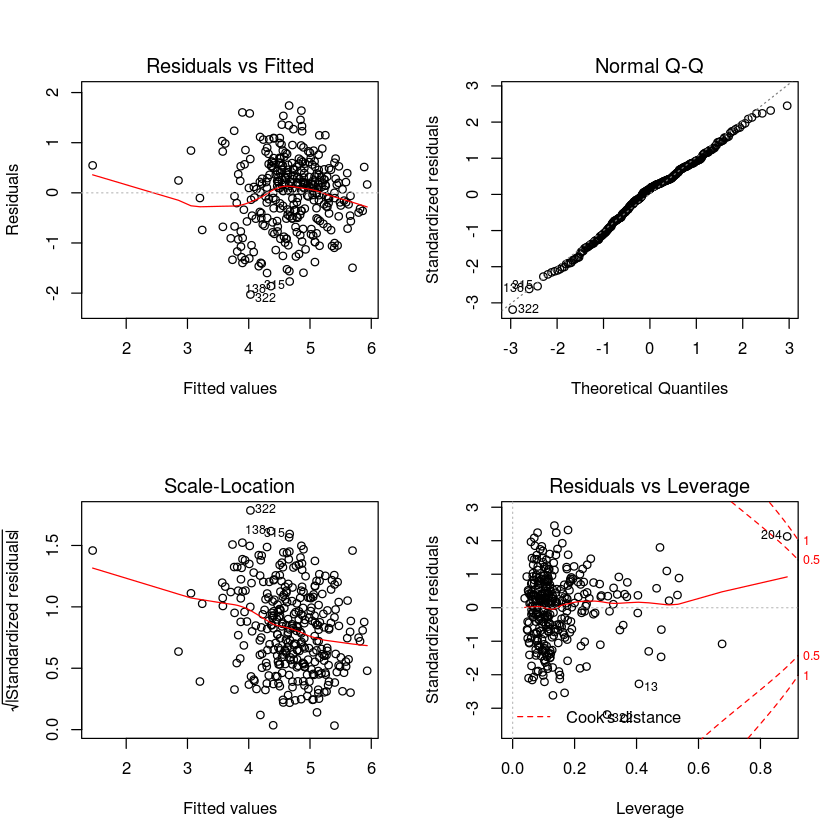

In [4]:
par(mfrow = c(2,2))
plot(A_baseline)

## Model 2 - multicollinearity

In [5]:
#remove multicollinearity
vif(A_baseline)[vif(A_baseline) > 10]
modelA2 = update(A_baseline, ~. 
                -mean.conf.pitch 
                -mean.spec.entropy
                -mean.num.apeak
                -avg.voice.seg
                -negative
                -postive)
summary(modelA2)

mean.conf.pitch mean.spec.entropy    mean.num.apeak    avg.voiced.seg 
         11.57107          10.27732          11.89223          11.62388


Call:
lm(formula = Agr ~ gender + mean.pitch + sd.pitch + sd.conf.pitch + 
    sd.spec.entropy + mean.val.apeak + sd.val.apeak + mean.loc.apeak + 
    sd.loc.apeak + sd.num.apeak + mean.energy + sd.energy + mean.d.energy + 
    sd.d.energy + avg.voiced.seg + avg.len.seg + time.speaking + 
    voice.rate + num.turns + hogv.entropy + hogv.median + hogv.cogR + 
    hogv.cogC + words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_Neuroticism + words_Openness + words_nExtraversion + 
    words_nAgreeableness + words_nConscientiousness + words_nNeuroticism + 
    words_nOpenness + anger + anticipation + disgust + fear + 
    joy + positive + sadness + surprise + trust + sentiment, 
    data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0338 -0.4517  0.1217  0.4762  1.8446 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.900742   0.078429  62.486  < 2e-16 ***
genderMale        

## Model 3 - Backward selection

In [6]:
#remove variables with p > 0.3
to_remove = ols_step_backward(modelA2)
paste(to_remove$removed, collapse = " - ")
modelA3 = update(modelA2, ~.
                 -mean.d.energy 
                 -mean.pitch 
                 -sd.loc.apeak 
                 -words_nExtraversion 
                 -words_nOpenness 
                 -words_nNeuroticism 
                 -mean.loc.apeak 
                 -words_Openness 
                 -avg.len.seg 
                 -sd.conf.pitch 
                 -sd.pitch 
                 -sd.spec.entropy 
                 -sd.num.apeak 
                 -hogv.median 
                 -sd.d.energy 
                 -mean.energy 
                 -anticipation 
                 -joy 
                 -words_Neuroticism 
                 -num.turns 
                 -hogv.entropy 
                 -hogv.cogR)

We are eliminating variables based on p value...
No more variables satisfy the condition of prem: 0.3


[1] "sd.num.apeak - sd.d.energy - mean.pitch - anticipation - fear - voice.rate - words_nOpenness - sadness - words_nNeuroticism - joy - avg.len.seg - mean.d.energy - sd.conf.pitch - words_nExtraversion - words_Openness - sd.spec.entropy - mean.energy - mean.loc.apeak - hogv.median - time.speaking - mean.val.apeak - avg.voiced.seg - num.turns - sd.pitch - hogv.entropy - hogv.cogR - words_Extraversion - sentiment"


Call:
lm(formula = Agr ~ gender + mean.val.apeak + sd.val.apeak + sd.energy + 
    avg.voiced.seg + time.speaking + voice.rate + hogv.cogC + 
    words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_nAgreeableness + words_nConscientiousness + anger + 
    disgust + fear + positive + sadness + surprise + trust + 
    sentiment, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9395 -0.4364  0.1173  0.4930  1.9224 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.910218   0.060593  81.036  < 2e-16 ***
genderMale               -0.441577   0.090439  -4.883  1.7e-06 ***
mean.val.apeak            0.057197   0.059881   0.955 0.340246    
sd.val.apeak              0.123992   0.056481   2.195 0.028905 *  
sd.energy                -0.060189   0.046488  -1.295 0.196411    
avg.voiced.seg            0.080974   0.068138   1.188 0.235621    
time.speaking             0.018907   0.0467

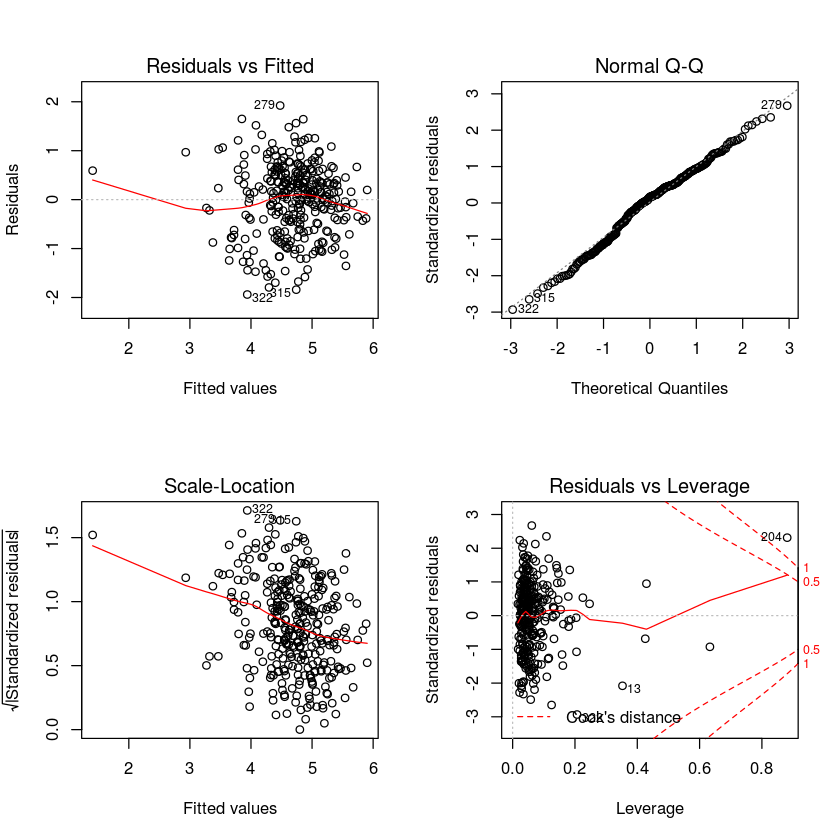

In [7]:
summary(modelA3)
par(mfrow = c(2,2))
plot(modelA3)

## Model 4 - remove outliers

No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferonni p
322 -2.970266           0.003215           NA


Call:
lm(formula = Agr ~ gender + mean.val.apeak + sd.val.apeak + sd.energy + 
    avg.voiced.seg + time.speaking + voice.rate + hogv.cogC + 
    words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_nAgreeableness + words_nConscientiousness + anger + 
    disgust + fear + positive + sadness + surprise + trust + 
    sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.75991 -0.44986  0.08891  0.45060  1.94184 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.91704    0.05987  82.132  < 2e-16 ***
genderMale               -0.44009    0.08929  -4.929 1.37e-06 ***
mean.val.apeak            0.02119    0.06035   0.351 0.725801    
sd.val.apeak              0.08941    0.05697   1.570 0.117565    
sd.energy                -0.07272    0.04609  -1.578 0.115675    
avg.voiced.seg            0.05047    0.06805   0.742 0.458841    
time.speaking             0.02129    0.0

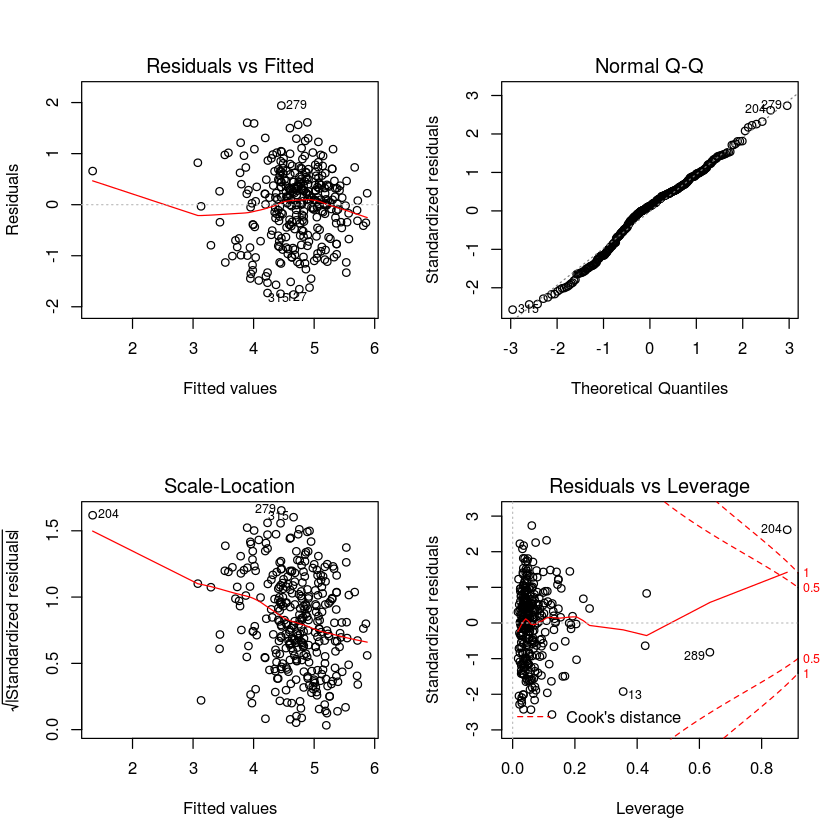

In [8]:
outlierTest(modelA3)
training_data = training_data[-322,]
modelA4 = update(modelA3)
summary(modelA4)
par(mfrow = c(2,2))
plot(modelA4)

## Model 5 - Non linear relationships

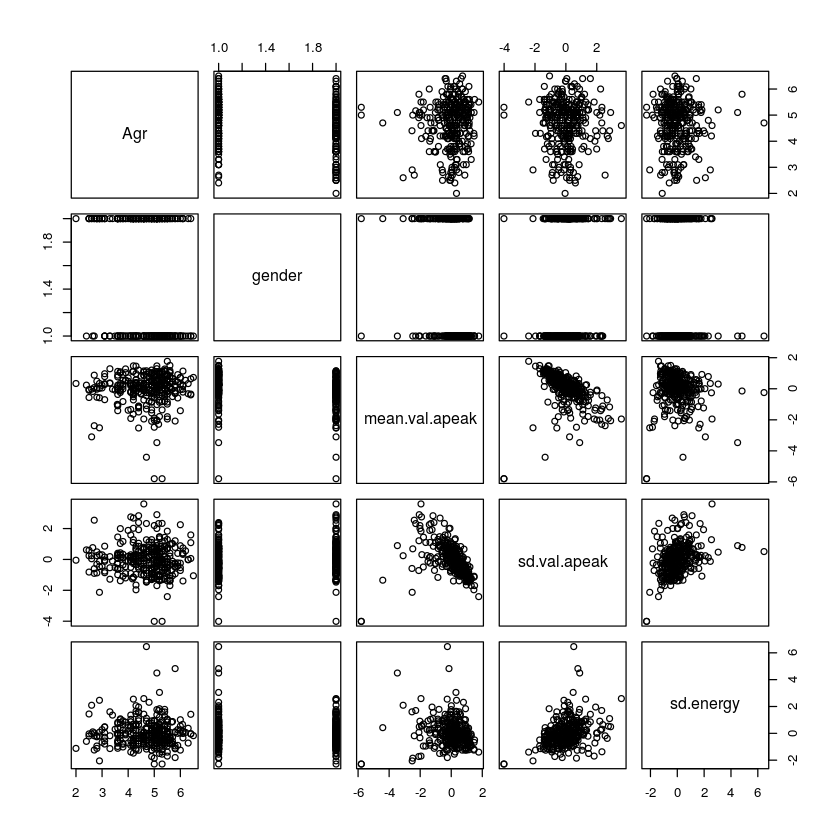

In [10]:
new_data = 
  training_data %>%
  select(Agr, gender, mean.val.apeak, sd.val.apeak,
         sd.energy, avg.voiced.seg,
         time.speaking, voice.rate,hogv.cogC,
         words_Extraversion, words_Agreeableness,
         words_Conscientiousness, words_nAgreeableness,
         words_nConscientiousness, anger, disgust, fear,
         positive, sadness, surprise, trust, sentiment)

pairs(new_data[,c(1:5)])

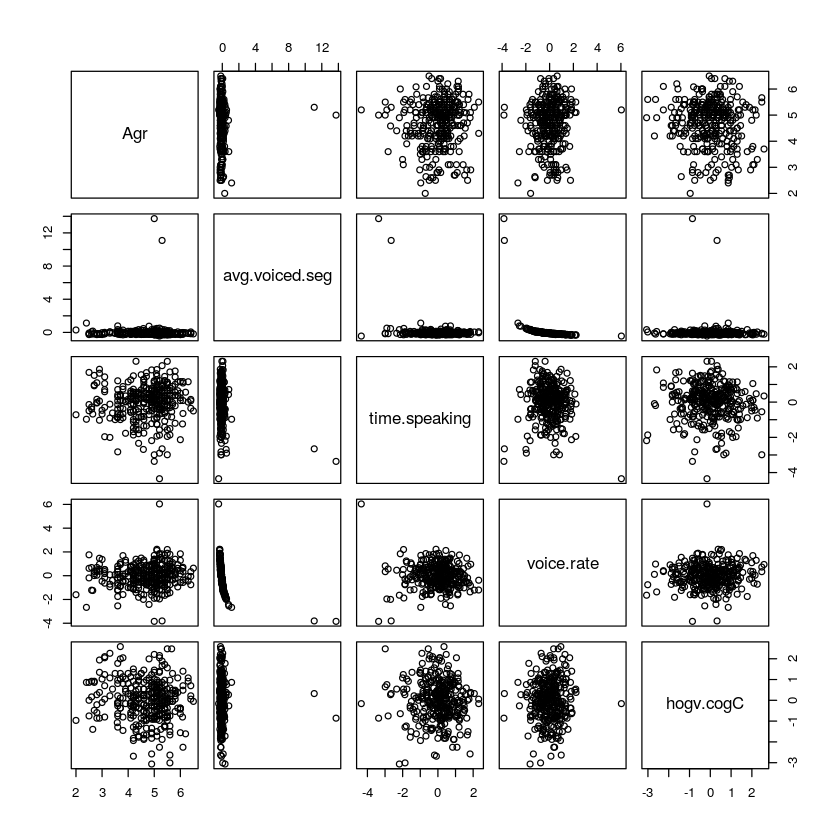

In [11]:
pairs(new_data[,c(1,6:9)])

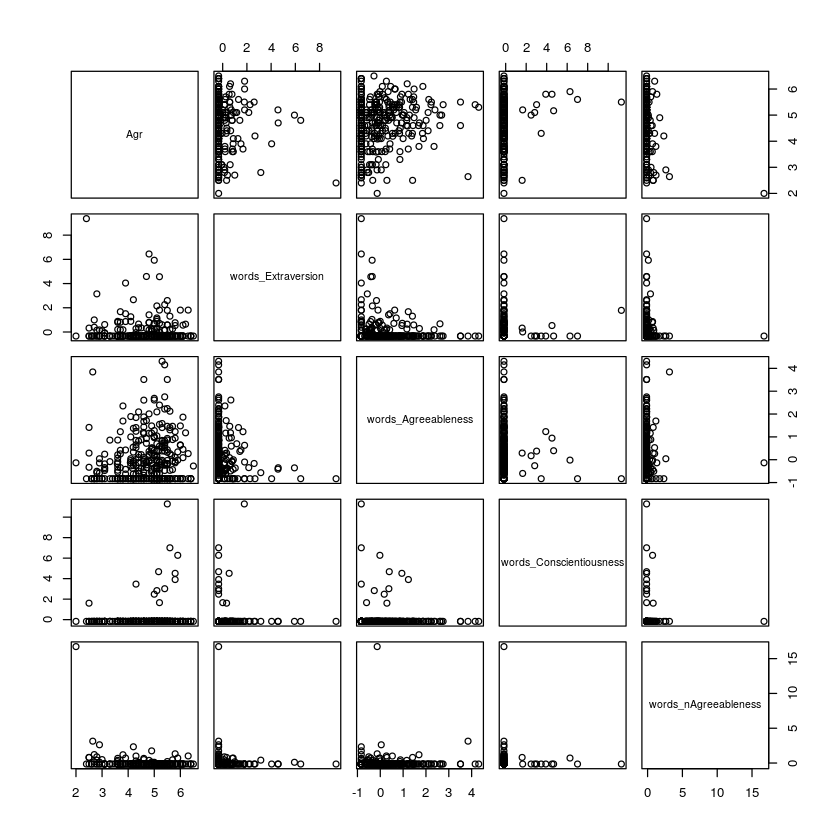

In [12]:
pairs(new_data[,c(1,10:13)])

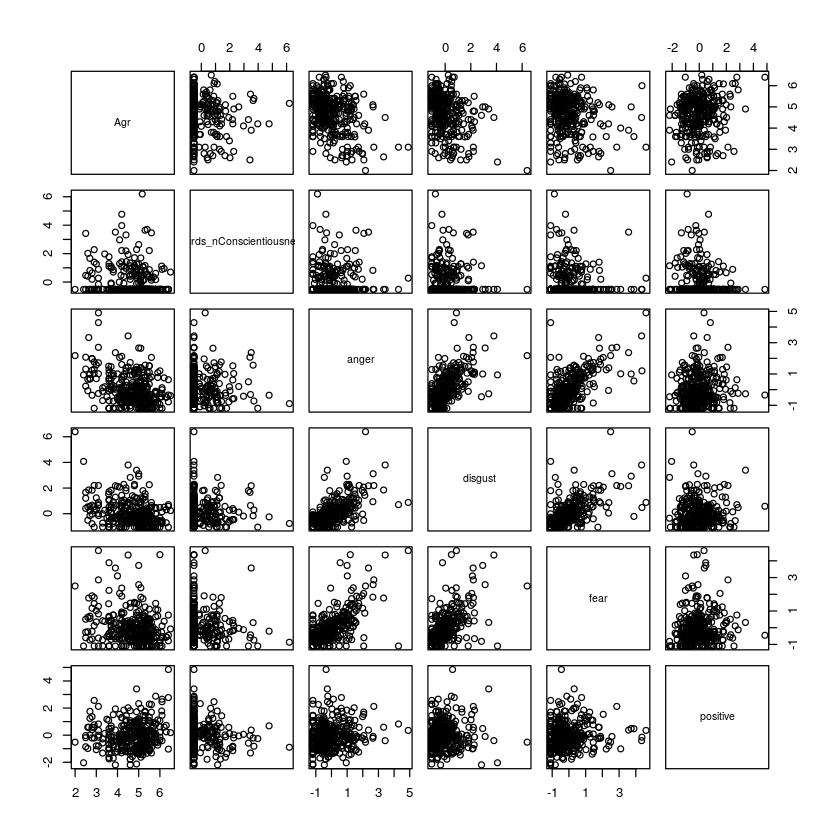

In [13]:
pairs(new_data[,c(1,14:18)])

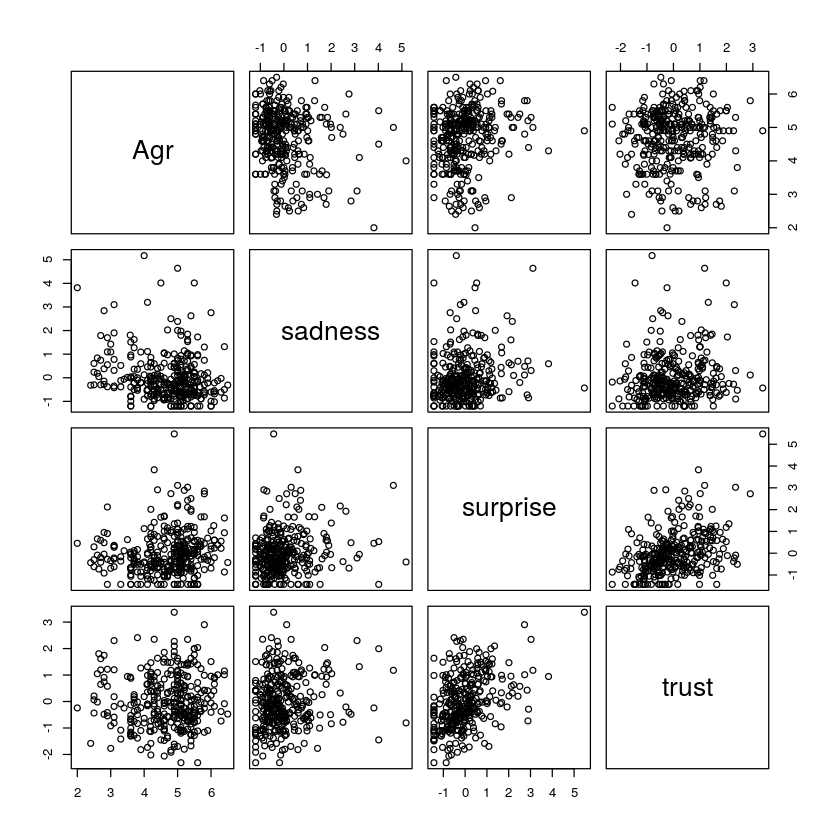

In [14]:
pairs(new_data[,c(1,19:21)])

In [17]:
modelA5 = update(modelA4, ~. + I(words_Agreeableness**2))
summary(modelA5)


Call:
lm(formula = Agr ~ gender + mean.val.apeak + sd.val.apeak + sd.energy + 
    avg.voiced.seg + time.speaking + voice.rate + hogv.cogC + 
    words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_nAgreeableness + words_nConscientiousness + anger + 
    disgust + fear + positive + sadness + surprise + trust + 
    sentiment + I(words_Agreeableness^2), data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7718 -0.4406  0.1034  0.4324  1.9990 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.98487    0.06685  74.572  < 2e-16 ***
genderMale               -0.45000    0.08882  -5.066 7.10e-07 ***
mean.val.apeak            0.03272    0.06018   0.544 0.587057    
sd.val.apeak              0.09077    0.05660   1.604 0.109831    
sd.energy                -0.07103    0.04580  -1.551 0.121985    
avg.voiced.seg            0.05272    0.06762   0.780 0.436223    
time.speaking          

## Model 6 - Interactions

In [18]:
modelA6 = update(modelA5, ~. + gender:words_nConscientiousness
              + gender:positive
              + gender:time.speaking)
summary(modelA6)


Call:
lm(formula = Agr ~ gender + mean.val.apeak + sd.val.apeak + sd.energy + 
    avg.voiced.seg + time.speaking + voice.rate + hogv.cogC + 
    words_Extraversion + words_Agreeableness + words_Conscientiousness + 
    words_nAgreeableness + words_nConscientiousness + anger + 
    disgust + fear + positive + sadness + surprise + trust + 
    sentiment + I(words_Agreeableness^2) + gender:words_nConscientiousness + 
    gender:positive + gender:time.speaking, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.92977 -0.43212  0.06442  0.43994  2.14878 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          4.988557   0.066453  75.069  < 2e-16 ***
genderMale                          -0.450339   0.088198  -5.106 5.89e-07 ***
mean.val.apeak                       0.042053   0.059912   0.702 0.483288    
sd.val.apeak                         0.090880   0.056191   1.617 0.106867    
sd.en